In [1]:
import pandas as pd
import seaborn as sns
import pandas.api.types as ptypes
import numpy as np
import optuna
from step import *
import plotly
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, KFold

In [2]:
df1 = pd.read_csv("../data/joao_pessoa.csv").drop(columns=["andar"])
df2 = pd.read_csv("../data/joao_pessoa1.csv") \
    .drop(columns=["z_lat", "z_lon", "bairro_completo",
                   "comercio", "bairro", "zona"]) \
    .transform(lambda x: x.apply(lambda y: float(y)) if ptypes.is_bool_dtype(x) else x)
df = pd.concat([df1, df2]) \
    .drop_duplicates("id") \
    .reset_index(drop=True) \
    .drop(columns=["id", "url"])

## Cleaning

In [3]:
def remove_outliers_iqr(data, feature, threshold=1.5):
    df = data.copy()
    q1, q3 = np.percentile(df[feature],  [1, 99])
    iqr = q3 - q1
    upper_bound = q3 + threshold * iqr

    removed_rows = df[df[feature] > upper_bound].index

    if(feature == 'valor'):
        df = df.drop(removed_rows, axis=0)
        return df.query("valor >= 40000").reset_index(drop=True)
    else:
        return df.drop(removed_rows, axis=0).reset_index(drop=True)


In [4]:
df = df.fillna(
    value={
        "academia": 0, "area_servico": 0,
        "elevador": 0, "espaco_gourmet": 0,
        "piscina": 0, "playground": 0,
        "portaria_24_horas": 0, "quadra_de_esporte": 0,
        "salao_de_festa": 0, "sauna": 0,
        "spa": 0, "varanda_gourmet": 0}
    ) \
    .replace(["flat", "terrenos_lotes_condominio"],
             ["flats", "terrenos_lotes_e_condominios"]) \
    .assign(
        latitude_norm=lambda x: (x.latitude - x.latitude.mean()) / x.latitude.std(),
        longitude_norm=lambda x: (x.longitude - x.longitude.mean()) / x.longitude.std(),
    ) \
    .query("-2 < latitude_norm < 2") \
    .query("-2 < longitude_norm < 2") \
    .query("area < 150000 and area >= 20 and valor < 12_000_000 and valor > 40000") \
    .query("tipo not in ['casas_de_vila', 'sobrados', 'coberturas']") \
    .reset_index(drop=True) \
    .drop(columns=["longitude_norm", "latitude_norm"])

In [5]:
df = remove_outliers_iqr(
    df.assign(
        valor_area = df.valor * df.area
        ),
    "valor_area"
    ) \
    .drop(columns=["valor_area"])

## Train and test dataset

In [6]:
df['valor_cut'] = pd.cut(df['valor'],
    bins=[0.,2e5, 4e5, 6e5, 8e5, np.inf],
    labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df.valor_cut):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]
train_df = train_df.drop(columns=["valor_cut", "endereco"]).reset_index(drop=True)
test_df = test_df.drop(columns=["valor_cut", "endereco"]).reset_index(drop=True)

## Missing values

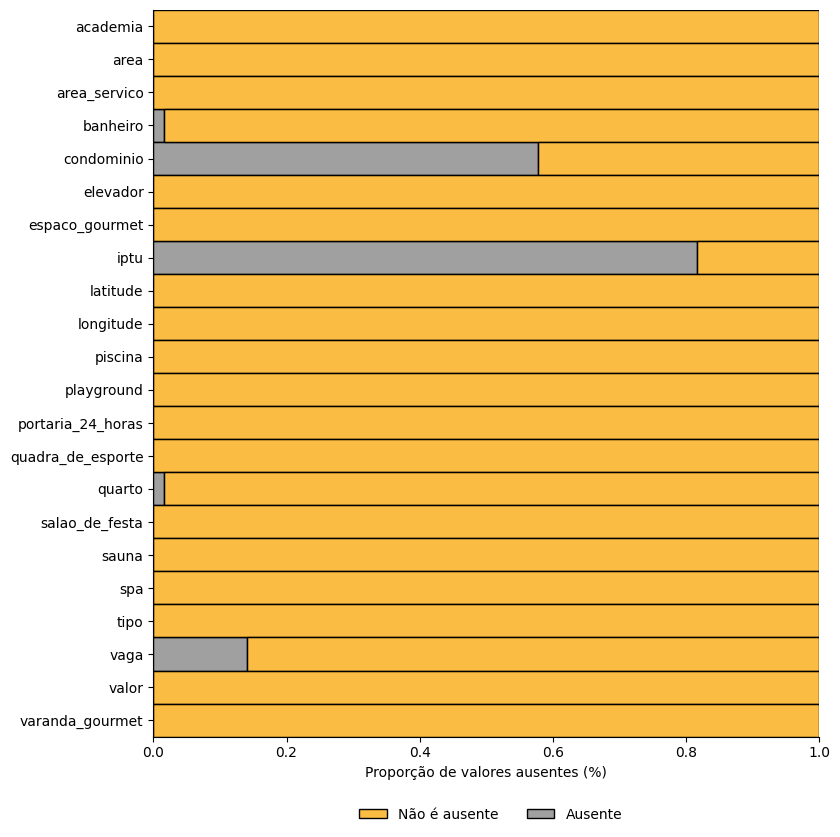

In [7]:
g_missing = sns.displot(
    data=train_df.isnull() \
        .melt(value_name="Valores ausentes") \
        .replace([False, True], ["Não é ausente", "Ausente"]) \
        .groupby(["variable", "Valores ausentes"]).size() \
        .reset_index(name="count") \
        .assign(
            proportion=lambda x: x.groupby("variable")["count"].transform(lambda y: y / y.sum())
        ),
    y="variable",
    hue="Valores ausentes",
    weights="proportion",
    multiple="fill",
    height=8,
    aspect=1.1,
    palette={"Não é ausente": "#f9a602", "Ausente": "gray"}
    )

sns.move_legend(obj=g_missing, loc="upper center",
                bbox_to_anchor=(.5, -.0001), ncol=2, title="")
g_missing.set(xlabel="Proporção de valores ausentes (%)", ylabel="")

## Modeling 

In [8]:
train_df = train_df.assign(valor=lambda x: np.log1p(x.valor))
test_df = test_df.assign(valor=lambda x: np.log1p(x.valor))

In [9]:
pipe_jp = Pipeline(
    [("imputer", Imputer()),
     ("engineering", BedAreaBedToi()),
     ("ordinal_encoder", OrdEncoder()),
     ("onehot_encoder", OneEncoder()),
    #  ("log_transform", LogTransform()),
     ("yeo-transform", YeoTransform()),
    #  ("scaling", Scale()),
    #  ("interpolate", Interpolate())
    ])
pipe_jp.fit(train_df)

Pipeline(steps=[('imputer', Imputer()), ('engineering', BedAreaBedToi()),
                ('ordinal_encoder', OrdEncoder()),
                ('onehot_encoder', OneEncoder()),
                ('yeo-transform', YeoTransform())])

In [10]:
train_df = pipe_jp.transform(train_df)
test_df = pipe_jp.transform(test_df)

In [11]:
forest = ensemble.RandomForestRegressor(n_estimators=1000, random_state=42, max_depth=1000, warm_start=True, n_jobs=-1)

In [12]:
forest.fit(X=train_df.drop(columns=["valor"]), y=train_df.valor)

RandomForestRegressor(max_depth=1000, n_estimators=1000, n_jobs=-1,
                      random_state=42, warm_start=True)

In [13]:
forest.score(X=test_df.drop(columns=["valor"]), y=test_df.valor)

0.8627919261762778

In [14]:
def objective_rf(trial):
    params = dict(
        n_estimators = trial.suggest_int(name='n_estimators', low=1, high=1000),
        max_depth = trial.suggest_int(name='max_depth', low=20, high=1000),
        # min_samples_split = trial.suggest_float(name='min_samples_split', low=1e-7, high=1, log=True),
        # min_samples_leaf = trial.suggest_float(name='min_samples_leaf', low=1e-7, high=1, log=True),
        # max_features = trial.suggest_float('max_features', 1e-6, 1.0),
        # min_weight_fraction_leaf = trial.suggest_float(name='min_weight_fraction_leaf', low=1e-7, high=0.5, log=True),
        # max_leaf_nodes = trial.suggest_int(name='max_leaf_nodes', low=2, high=300),
        min_impurity_decrease = trial.suggest_float(name='min_impurity_decrease', low=1e-7, high=10, log=True),
        # bootstrap = trial.suggest_categorical('bootstrap', [True, False]),
        random_state=42
    )

    model = ensemble.RandomForestRegressor(
        **params,
        n_jobs=3
    )
    model.fit(X=train_df.drop('valor', axis=1), y=train_df.valor)

    cv_scores = np.exp(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df.drop("valor", axis=1),
        y=train_df.valor,
        scoring="neg_mean_squared_error",
        n_jobs=3,
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)


In [15]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_rf, n_trials=100)

[I 2024-06-10 06:56:39,761] A new study created in memory with name: no-name-fd28fe78-8d67-4af6-8a0e-89c85209e279
[I 2024-06-10 06:58:09,411] Trial 0 finished with value: 1.2928082014110964 and parameters: {'n_estimators': 332, 'max_depth': 676, 'min_impurity_decrease': 1.335513326647804e-06}. Best is trial 0 with value: 1.2928082014110964.
[I 2024-06-10 06:59:57,771] Trial 1 finished with value: 1.3212561835006036 and parameters: {'n_estimators': 637, 'max_depth': 499, 'min_impurity_decrease': 6.028001632581856e-05}. Best is trial 0 with value: 1.2928082014110964.
[I 2024-06-10 07:00:32,404] Trial 2 finished with value: 1.7216743552488292 and parameters: {'n_estimators': 864, 'max_depth': 757, 'min_impurity_decrease': 0.12520837838688012}. Best is trial 0 with value: 1.2928082014110964.
[I 2024-06-10 07:00:39,930] Trial 3 finished with value: 1.3112921769300194 and parameters: {'n_estimators': 37, 'max_depth': 151, 'min_impurity_decrease': 3.185968995257272e-05}. Best is trial 0 with 

In [ ]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [min_samples_leaf (FloatDistribution):
                                0.00011680634552414679<extra></extra>, n_estimators
                                (IntDistribution):
                                0.015022530399243054<extra></extra>, max_leaf_nodes
                                (IntDistribution):
                                0.04635601529304639<extra></extra>, max_depth
                                (IntDistribution):
                                0.059598758762016806<extra></extra>, max_features
                                (FloatDistribution):
                                0.29599990756628447<extra></extra>,
                                min_impurity_decrease (FloatDistribution):
                                0.5829059816338852<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, 0.02, 0.05, 0.06, 0.30, 0.58],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.00011680634552414679, 0.015022530399243054,
                    0.04635601529304639, 0.059598758762016806, 0.29599990756628447,
                    0.5829059816338852],
              'y': [min_samples_leaf, n_estimators, max_leaf_nodes, max_depth,
                    max_features, min_impurity_decrease]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})